In [17]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageDraw
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader



In [18]:
def create_dataset_folders(base_path="dataset"):
    for split in ["train", "test"]:
        split_path = os.path.join(base_path, split)
        os.makedirs(split_path, exist_ok=True)
        for digit in range(10):
            os.makedirs(os.path.join(split_path, str(digit)), exist_ok=True)


In [19]:
def generate_and_save_data(num_samples, img_size, split, base_path="dataset"):
    images = []
    labels = []
    split_path = os.path.join(base_path, split)
    
    for i in range(num_samples):
        img = Image.new('L', img_size, color=0)  # Black background
        draw = ImageDraw.Draw(img)
        label = np.random.randint(0, 10)  # 10 classes (digits 0-9)
        draw.text((5, 5), str(label), fill=255)  # Draw number as white text
        img_array = np.array(img, dtype=np.uint8)
        images.append(img_array)
        labels.append(label)
        
        img_save_path = os.path.join(split_path, str(label), f"image_{i}.png")
        img.save(img_save_path)
    
    return np.array(images, dtype=np.float32), np.array(labels, dtype=np.int32)




In [20]:
class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.tensor(images).unsqueeze(1) / 255.0  # Normalize and add channel dim
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [21]:
class CapsuleNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CapsuleNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 256, kernel_size=9, stride=1, padding=0)
        self.primary_caps = nn.Conv2d(256, 32 * 8, kernel_size=9, stride=2, padding=0)
        self.fc = nn.Linear(32 * 8 * 6 * 6, num_classes * 16)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.primary_caps(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = x.view(x.size(0), 10, 16)
        return torch.norm(x, dim=2)


In [22]:
num_samples = 20  # Use only 20 images
img_size = (28, 28)
base_path = "dataset"

create_dataset_folders(base_path)
train_images, train_labels = generate_and_save_data(num_samples, img_size, "train", base_path)
test_images, test_labels = generate_and_save_data(num_samples // 5, img_size, "test", base_path)

train_dataset = CustomDataset(train_images, train_labels)
test_dataset = CustomDataset(test_images, test_labels)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)



In [23]:
model = CapsuleNet()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")


Epoch 1/10, Loss: 2.3109
Epoch 2/10, Loss: 2.2474
Epoch 3/10, Loss: 2.0375
Epoch 4/10, Loss: 1.6725
Epoch 5/10, Loss: 1.3825
Epoch 6/10, Loss: 1.0064
Epoch 7/10, Loss: 0.1491
Epoch 8/10, Loss: 0.1873
Epoch 9/10, Loss: 0.1136
Epoch 10/10, Loss: 0.0341


In [24]:
torch.save(model.state_dict(), "capsule_torch_model.pth")


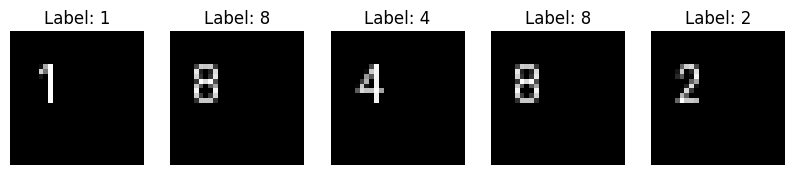

In [25]:
def display_sample_images(images, labels, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
    for i in range(num_images):
        axes[i].imshow(images[i], cmap='gray')
        axes[i].set_title(f"Label: {labels[i]}")
        axes[i].axis('off')
    plt.show()

display_sample_images(train_images, train_labels)

